In [1]:
# pip install opencv-python

In [2]:
import matplotlib
import sklearn
import numpy as np
import pandas as pd
import sklearn.metrics as metrics
import matplotlib.pyplot as plt
import pathlib
import os
import cv2
import datetime

from os import listdir
from os.path import isfile, isdir, join
from pathlib import Path

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import ModelCheckpoint,CSVLogger
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.utils import plot_model
from tensorflow.keras import optimizers
from tensorflow.keras import regularizers
from keras.models import load_model
from keras.models import Model
from tensorflow.keras.layers import concatenate

from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split

print("Versions of key libraries")
print("---")
print("tensorflow: ", tf.__version__)
print("numpy:      ", np.__version__)
print("matplotlib: ", matplotlib.__version__)
print("sklearn:    ", sklearn.__version__)
print(tf.config.list_physical_devices())

Versions of key libraries
---
tensorflow:  2.9.0
numpy:       1.22.3
matplotlib:  3.5.2
sklearn:     1.1.1
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
members_param = [
    {
        "model_name": "main",
        "file_path": "./models/medium_best.hdf5",
        "class_names": ['arowana', 'betta', 'goldfish', 'luohan'],
        "img_width": 224,
        "img_height":160
    },
    {
        "model_name": "simple",
        "file_path": "./models/simple_best.hdf5",
        "class_names": ['arowana', 'betta', 'goldfish', 'luohan'],
        "img_width": 160,
        "img_height":160
    },
    {
        "model_name": "grayscale",
        "file_path": "./models/grayscale_best.hdf5",
        "class_names": ['arowana', 'betta', 'goldfish', 'luohan'],
        "img_width": 80,
        "img_height":60,
        "channels":1
    }
]

model_files = [
    {
        "model_name": "ensemble",
        "file_path": "./models/ensemble_best.hdf5",
        "class_names": ['arowana', 'betta', 'goldfish', 'luohan'],
        "ensemble": True
    },
    {
        "model_name": "main",
        "file_path": "./models/medium_best.hdf5",
        "class_names": ['arowana', 'betta', 'goldfish', 'luohan'],
        "main": True
    },
    {
        "model_name": "simple",
        "file_path": "./models/simple_best.hdf5",
        "class_names": ['arowana', 'betta', 'goldfish', 'luohan'],
        "simple": True
    },
    {
        "model_name": "grayscale",
        "file_path": "./models/grayscale_best.hdf5",
        "class_names": ['arowana', 'betta', 'goldfish', 'luohan'],
        "grayscale": True
    },
    {
        "model_name": "fish",
        "file_path": "./models/Hybrid_best.hdf5",
        "class_names": ['arowana', 'betta', 'goldfish', 'luohan'],
        "fish": True
    },
    {
        "model_name": "arowana",
        "file_path": "./models/arowana_best.hdf5",
        "class_names": ['arowana', 'not arowana'],
        "single": True
    },
    {
        "model_name": "betta",
        "file_path": "./models/betta_best.hdf5",
        "class_names": ['betta', 'not betta'],
        "single": True
    },
    {
        "model_name": "goldfish",
        "file_path": "./models/goldfish_best.hdf5",
        "class_names": ['goldfish', 'not goldfish'],
        "single": True
    },
    {
        "model_name": "flowerhorn",
        "file_path": "./models/luohan_best.hdf5",
        "class_names": ['luohan', 'not luohan'],
        "single": True
    }
]

modelname   = 'ensemble'
BATCH_SIZE = 32 # Big enough to measure an F1-score
AUTOTUNE = tf.data.AUTOTUNE # Adapt preprocessing and prefetching dynamically
SHUFFLE_BUFFER_SIZE = 1024 # Shuffle the training data by a chunck of 1024 observations
IMG_WIDTH = 224
IMG_HEIGHT = 160
CHANNELS = 3
SEED = 42
N_LABELS = 4
EPOCHS = 15
OPT_IDX = 2
ACTIVATION = 'softmax'

class_names = ''
modelname = modelname+"_"+ACTIVATION+"_"+str(EPOCHS)+"_"+str(BATCH_SIZE)+"_"+str(OPT_IDX)
optmzs = ['adam', optimizers.RMSprop(learning_rate=0.0001), optimizers.Adam(learning_rate=0.001)]
optmz = optmzs[OPT_IDX]

In [4]:
def readImagesFromDir(base_img_path='dataset/'):
    dirs = [d for d in listdir(base_img_path) if isdir(join(base_img_path, d)) and not d.startswith('.') and not d in ['oranda', 'common_goldfish']]

    print(dirs)

    X, y = [], []

    for d in dirs:
        img_path = base_img_path + d + "/"
        files = [f for f in listdir(img_path) if isfile(join(img_path, f))]
        X = X + [os.path.join(img_path, f) for f in files if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
        y = y + [d for f in files if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
        #print(d)

    data_dir = Path(base_img_path)
    image_count = len(list(data_dir.glob('*/*.*')))
    
    return X, y


def preprocess_image(filename, label):
    """Function that returns a tuple of normalized image array and labels array.
    Args:
        filename: string representing path to image
        label: 0/1 one-dimensional array of size N_LABELS
    """
    # Read an image from a file
    images = {}
    image_string = tf.io.read_file(filename)
    
#     image_resized = tf.image.resize_with_pad(image_decoded, IMG_HEIGHT, IMG_WIDTH, antialias=False)
#     image_normalized = image_resized / 255.0
    for i,m in enumerate(members_param):
        ch = m.get("channels", 3)
        image_decoded = tf.image.decode_jpeg(image_string, channels=ch)
        image_resized = tf.image.resize_with_pad(image_decoded, m["img_height"], m["img_width"], antialias=False)
        image_normalized = image_resized / 255.0
        images["input_"+str(i)] = image_normalized
        
    return images, label


# def create_dataset(filenames, labels, is_training=False):
#     dataset = tf.data.Dataset.from_tensor_slices((filenames, labels))
#     dataset = dataset.map(preprocess_image, num_parallel_calls=AUTOTUNE)
#     if is_training == True:
#         dataset = dataset.shuffle(buffer_size=SHUFFLE_BUFFER_SIZE) 
#     dataset = dataset.batch(BATCH_SIZE)
#     dataset = dataset.prefetch(buffer_size=AUTOTUNE)
#     return dataset
    
def visualize_image(original, augmented):
    org_img = tf.keras.utils.array_to_img(original)
    fig = plt.figure()
    plt.subplot(1,2,1)
    plt.title('Original image')
    plt.imshow(org_img)

    aug_img = tf.keras.utils.array_to_img(augmented)
    plt.subplot(1,2,2)
    plt.title('Augmented image')
    plt.imshow(aug_img)


def predict_new_image(model, img_file):    
    #img = tf.keras.utils.load_img(
    #    img_file, target_size=(IMG_HEIGHT, IMG_WIDTH), keep_aspect_ratio=True
    #)
#     load and show the image
    image = tf.keras.utils.load_img(
        img_file, target_size=None, keep_aspect_ratio=True
    )
    plt.imshow(image)
    plt.show()

#     predict with the model
    images = []

    for i, m in enumerate(members_param):
        grayscale = m.get("channels", 3) == 1
        img = tf.keras.utils.load_img(
            img_file, target_size=None, keep_aspect_ratio=True, grayscale=grayscale
        )
        img_array = tf.keras.utils.img_to_array(img)
        image_resized = tf.keras.preprocessing.image.smart_resize(
            img_array, size=(m["img_height"], m["img_width"]))
        image_normalized = image_resized / 255.0
        images.append(np.expand_dims(image_normalized, 0))

    predictions = model.predict(images)
    score = tf.nn.softmax(predictions[0])

    print(
        "This image most likely belongs to {} with a {:.2f} percent confidence."
        .format(class_names[np.argmax(score)], 100 * np.max(score))
    )
    print()

In [5]:
def readImagesFromDirForSingle(base_img_path='dataset/', fishType='betta'):
    dirs = [d for d in listdir(base_img_path) if isdir(join(base_img_path, d)) and not d.startswith('.') and not d in ['oranda', 'common_goldfish']]
    print(dirs)
    X, y = [], []
    for d in dirs:
        img_path = base_img_path + d + "/"
        files = [f for f in listdir(img_path) if isfile(join(img_path, f))]
        X = X + [os.path.join(img_path, f) for f in files if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
        y = y + [fishType if d==fishType else 'not '+fishType for f in files if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
        #print(d)
    data_dir = Path(base_img_path)
    image_count = len(list(data_dir.glob('*/*.*')))
    return X, y


In [6]:
def preprocess_image_single(filename, label):
    image_string = tf.io.read_file(filename)
    image_decoded = tf.image.decode_jpeg(image_string, channels=CHANNELS)
    image_resized = tf.image.resize_with_pad(image_decoded, 128, 128, antialias=False)
    image_normalized = image_resized / 255.0
    
    return image_normalized, label

def preprocess_image_main(filename, label):
    image_string = tf.io.read_file(filename)
    image_decoded = tf.image.decode_jpeg(image_string, channels=CHANNELS)
    image_resized = tf.image.resize_with_pad(image_decoded, 160, 224, antialias=False)
    image_normalized = image_resized / 255.0
    
    return image_normalized, label

def preprocess_image_simple(filename, label):
    image_string = tf.io.read_file(filename)
    image_decoded = tf.image.decode_jpeg(image_string, channels=CHANNELS)
    image_resized = tf.image.resize_with_pad(image_decoded, 160, 160, antialias=False)
    image_normalized = image_resized / 255.0
    
    return image_normalized, label

def preprocess_image_fish(filename, label):
    image_string = tf.io.read_file(filename)
    image_decoded = tf.image.decode_jpeg(image_string, channels=CHANNELS)
    image_resized = tf.image.resize_with_pad(image_decoded, 64, 64, antialias=False)
    image_normalized = image_resized / 255.0
    
    return image_normalized, label

def preprocess_image_grayscale(filename, label):
    image_string = tf.io.read_file(filename)
    image_decoded = tf.image.decode_jpeg(image_string, channels=1)
    image_resized = tf.image.resize_with_pad(image_decoded, 60, 80, antialias=False)
    image_normalized = image_resized / 255.0
    
    return image_normalized, label

def create_dataset(filenames, labels, is_ensemble=False, is_main=False, is_single=False, is_simple=False, is_grayscale=False, is_fish=False):
    dataset = tf.data.Dataset.from_tensor_slices((filenames, labels))
    if is_main:
        dataset = dataset.map(preprocess_image_main, num_parallel_calls=AUTOTUNE)
    if is_single:
        dataset = dataset.map(preprocess_image_single, num_parallel_calls=AUTOTUNE)
    if is_simple:
        dataset = dataset.map(preprocess_image_simple, num_parallel_calls=AUTOTUNE)
    if is_grayscale:
        dataset = dataset.map(preprocess_image_grayscale, num_parallel_calls=AUTOTUNE)
    if is_fish:
        dataset = dataset.map(preprocess_image_fish, num_parallel_calls=AUTOTUNE)
    if is_ensemble:
        dataset = dataset.map(preprocess_image, num_parallel_calls=AUTOTUNE)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(buffer_size=AUTOTUNE)
    
    return dataset

In [7]:
X, Y = readImagesFromDir()

X_train, X_val, y_train, y_val = train_test_split(X, Y, test_size=0.2, shuffle=True, random_state=SEED)

lb = LabelBinarizer()
lb.fit(Y)
class_names = lb.classes_
N_LABELS = len(class_names)
for (i, label) in enumerate(class_names):
    print("{}. {}".format(i, label))

y_bin = lb.transform(Y)
print(y_bin.shape)

['arowana', 'betta', 'goldfish', 'luohan']
0. arowana
1. betta
2. goldfish
3. luohan
(11443, 4)


In [8]:
yout     = np.argmax(y_bin,axis=1)

df = pd.DataFrame()
df["file"] = X
df["fish"] = Y
df["yout"] = yout

models = {}

for m in model_files:
    mod = load_model(m["file_path"])
    if m.get("main", False):
        main_ds = create_dataset(X,y_bin,is_main=True)
        main_pre = mod.predict(main_ds)
    if m.get("simple", False):
        simple_ds = create_dataset(X,y_bin,is_simple=True)
        simple_pre = mod.predict(simple_ds)
    if m.get("grayscale", False):
        grayscale_ds = create_dataset(X,y_bin, is_grayscale=True)
        grayscale_pre = mod.predict(grayscale_ds)
    if m.get("ensemble", False):
        ensemble_ds = create_dataset(X,y_bin, is_ensemble=True)
        ensemble_pre = mod.predict(ensemble_ds)

df["mout"] = np.argmax(main_pre,axis=1)
df["sout"] = np.argmax(simple_pre,axis=1)
df["gout"] = np.argmax(grayscale_pre,axis=1)
df["fout"] = np.argmax(ensemble_pre,axis=1)
df

358/358 [==============================] - 4s 12ms/step


,file,fish,yout,mout,sout,gout,fout
0,dataset/arowana/097_a_rare_experience_with_an_...,arowana,0,0,0,0,0
1,dataset/arowana/0CC2F84D-0C1C-413A-8008-681908...,arowana,0,2,0,1,2
2,dataset/arowana/105473010-1537987843171fish.jpg,arowana,0,0,0,0,0
3,dataset/arowana/1218481-7e36a33dc1efee3f82271f...,arowana,0,2,2,1,2
4,dataset/arowana/14032010655.jpg,arowana,0,2,2,2,2
...,...,...,...,...,...,...,...
11438,dataset/luohan/texas-cichlid-1024x768.jpg,luohan,3,1,0,3,3
11439,dataset/luohan/Thai-Silk-Flowerhorn.jpg,luohan,3,3,3,3,3
11440,dataset/luohan/thaisilk-flowerhorn-300x300.jpg,luohan,3,3,3,2,3
11441,dataset/luohan/v2-851a88687a2f576b8c6b21a454c7...,luohan,3,3,3,3,3


In [9]:
predout     = df["mout"]
testout     = yout

testScores  = metrics.accuracy_score(testout,predout)                           # Step 3

                                                                                # Step 4
print("Best accuracy (on testing dataset): %.2f%%" % (testScores*100))
print(metrics.classification_report(testout,
                                    predout,
                                    target_names=class_names,
                                    digits=4))

Best accuracy (on testing dataset): 92.47%
              precision    recall  f1-score   support

     arowana     0.9425    0.9112    0.9266      3006
       betta     0.9336    0.9560    0.9446      3043
    goldfish     0.8290    0.9773    0.8971      2203
      luohan     0.9844    0.8712    0.9244      3191

    accuracy                         0.9247     11443
   macro avg     0.9224    0.9289    0.9232     11443
weighted avg     0.9300    0.9247    0.9251     11443



In [10]:
predout     = df["sout"]
testout     = yout

testScores  = metrics.accuracy_score(testout,predout)                           # Step 3

                                                                                # Step 4
print("Best accuracy (on testing dataset): %.2f%%" % (testScores*100))
print(metrics.classification_report(testout,
                                    predout,
                                    target_names=class_names,
                                    digits=4))

Best accuracy (on testing dataset): 90.37%
              precision    recall  f1-score   support

     arowana     0.8801    0.8982    0.8890      3006
       betta     0.9135    0.9159    0.9147      3043
    goldfish     0.8440    0.9655    0.9007      2203
      luohan     0.9725    0.8546    0.9098      3191

    accuracy                         0.9037     11443
   macro avg     0.9025    0.9085    0.9035     11443
weighted avg     0.9078    0.9037    0.9039     11443



In [11]:
predout     = df["gout"]
testout     = yout

testScores  = metrics.accuracy_score(testout,predout)                           # Step 3

                                                                                # Step 4
print("Best accuracy (on testing dataset): %.2f%%" % (testScores*100))
print(metrics.classification_report(testout,
                                    predout,
                                    target_names=class_names,
                                    digits=4))

Best accuracy (on testing dataset): 87.49%
              precision    recall  f1-score   support

     arowana     0.8962    0.8703    0.8830      3006
       betta     0.9203    0.8462    0.8817      3043
    goldfish     0.7359    0.9510    0.8297      2203
      luohan     0.9465    0.8540    0.8979      3191

    accuracy                         0.8749     11443
   macro avg     0.8747    0.8804    0.8731     11443
weighted avg     0.8858    0.8749    0.8765     11443



In [12]:
predout     = df["fout"]
testout     = yout

testScores  = metrics.accuracy_score(testout,predout)                           # Step 3

                                                                                # Step 4
print("Best accuracy (on testing dataset): %.2f%%" % (testScores*100))
print(metrics.classification_report(testout,
                                    predout,
                                    target_names=class_names,
                                    digits=4))

Best accuracy (on testing dataset): 93.58%
              precision    recall  f1-score   support

     arowana     0.9411    0.9188    0.9298      3006
       betta     0.9439    0.9570    0.9504      3043
    goldfish     0.8620    0.9868    0.9202      2203
      luohan     0.9859    0.8963    0.9389      3191

    accuracy                         0.9358     11443
   macro avg     0.9332    0.9397    0.9348     11443
weighted avg     0.9391    0.9358    0.9360     11443



In [13]:
# df.to_csv("full.csv")

In [14]:
def readImagesFromDirClean(base_img_path='clean/'):
    dirs = [d for d in listdir(base_img_path) if isdir(join(base_img_path, d)) and not d.startswith('.') and not d in ['oranda', 'common_goldfish']]

    print(dirs)

    X, y = [], []

    for d in dirs:
        img_path = base_img_path + d + "/"
        files = [f for f in listdir(img_path) if isfile(join(img_path, f))]
        X = X + [os.path.join(img_path, f) for f in files if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
        y = y + [d for f in files if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
        #print(d)

    data_dir = Path(base_img_path)
    image_count = len(list(data_dir.glob('*/*.*')))
    
    return X, y

In [15]:
X_c, Y_c = readImagesFromDirClean()

lb = LabelBinarizer()
lb.fit(Y_c)
class_names = lb.classes_
N_LABELS = len(class_names)
for (i, label) in enumerate(class_names):
    print("{}. {}".format(i, label))

yc_bin = lb.transform(Y_c)
print(yc_bin.shape)

['arowana', 'betta', 'goldfish', 'luohan']
0. arowana
1. betta
2. goldfish
3. luohan
(8382, 4)


In [16]:
ycout     = np.argmax(yc_bin,axis=1)

dfc = pd.DataFrame()
dfc["file"] = X_c
dfc["fish"] = Y_c
dfc["yout"] = ycout

models = {}

for m in model_files:
    mod = load_model(m["file_path"])
    if m.get("main", False):
        main_ds = create_dataset(X_c,yc_bin,is_main=True)
        main_pre = mod.predict(main_ds)
    if m.get("simple", False):
        simple_ds = create_dataset(X_c,yc_bin,is_simple=True)
        simple_pre = mod.predict(simple_ds)
    if m.get("grayscale", False):
        grayscale_ds = create_dataset(X_c,yc_bin, is_grayscale=True)
        grayscale_pre = mod.predict(grayscale_ds)
    if m.get("ensemble", False):
        ensemble_ds = create_dataset(X_c,yc_bin, is_ensemble=True)
        ensemble_pre = mod.predict(ensemble_ds)

dfc["mout"] = np.argmax(main_pre,axis=1)
dfc["sout"] = np.argmax(simple_pre,axis=1)
dfc["gout"] = np.argmax(grayscale_pre,axis=1)
dfc["fout"] = np.argmax(ensemble_pre,axis=1)
dfc

262/262 [==============================] - 4s 13ms/step


,file,fish,yout,mout,sout,gout,fout
0,clean/arowana/Arowana_100000.jpg,arowana,0,0,0,0,0
1,clean/arowana/Arowana_100001.jpg,arowana,0,0,0,0,0
2,clean/arowana/Arowana_100002.jpg,arowana,0,0,0,0,0
3,clean/arowana/Arowana_100003.jpg,arowana,0,0,0,0,0
4,clean/arowana/Arowana_100004.jpg,arowana,0,0,0,0,0
...,...,...,...,...,...,...,...
8377,clean/luohan/Flowerhorn12170.jpg,luohan,3,3,3,3,3
8378,clean/luohan/Flowerhorn12171.jpg,luohan,3,3,3,3,3
8379,clean/luohan/Flowerhorn12172.jpg,luohan,3,3,3,3,3
8380,clean/luohan/Flowerhorn12173.jpg,luohan,3,3,3,3,3


In [17]:
predout     = dfc["mout"]
testout     = ycout

testScores  = metrics.accuracy_score(testout,predout)                           # Step 3

                                                                                # Step 4
print("Best accuracy (on testing dataset): %.2f%%" % (testScores*100))
print(metrics.classification_report(testout,
                                    predout,
                                    target_names=class_names,
                                    digits=4))

Best accuracy (on testing dataset): 98.23%
              precision    recall  f1-score   support

     arowana     0.9871    0.9935    0.9903      2010
       betta     0.9741    0.9907    0.9824      2051
    goldfish     0.9767    0.9776    0.9772      2146
      luohan     0.9915    0.9687    0.9800      2175

    accuracy                         0.9823      8382
   macro avg     0.9824    0.9827    0.9825      8382
weighted avg     0.9824    0.9823    0.9823      8382



In [18]:
predout     = dfc["sout"]
testout     = ycout

testScores  = metrics.accuracy_score(testout,predout)                           # Step 3

                                                                                # Step 4
print("Best accuracy (on testing dataset): %.2f%%" % (testScores*100))
print(metrics.classification_report(testout,
                                    predout,
                                    target_names=class_names,
                                    digits=4))

Best accuracy (on testing dataset): 97.17%
              precision    recall  f1-score   support

     arowana     0.9849    0.9761    0.9805      2010
       betta     0.9599    0.9805    0.9701      2051
    goldfish     0.9647    0.9669    0.9658      2146
      luohan     0.9781    0.9641    0.9711      2175

    accuracy                         0.9717      8382
   macro avg     0.9719    0.9719    0.9719      8382
weighted avg     0.9718    0.9717    0.9717      8382



In [19]:
predout     = dfc["gout"]
testout     = ycout

testScores  = metrics.accuracy_score(testout,predout)                           # Step 3

                                                                                # Step 4
print("Best accuracy (on testing dataset): %.2f%%" % (testScores*100))
print(metrics.classification_report(testout,
                                    predout,
                                    target_names=class_names,
                                    digits=4))

Best accuracy (on testing dataset): 96.68%
              precision    recall  f1-score   support

     arowana     0.9748    0.9826    0.9787      2010
       betta     0.9793    0.9478    0.9633      2051
    goldfish     0.9390    0.9539    0.9464      2146
      luohan     0.9758    0.9830    0.9794      2175

    accuracy                         0.9668      8382
   macro avg     0.9672    0.9668    0.9669      8382
weighted avg     0.9670    0.9668    0.9668      8382



In [20]:
predout     = dfc["fout"]
testout     = ycout

testScores  = metrics.accuracy_score(testout,predout)                           # Step 3

                                                                                # Step 4
print("Best accuracy (on testing dataset): %.2f%%" % (testScores*100))
print(metrics.classification_report(testout,
                                    predout,
                                    target_names=class_names,
                                    digits=4))

Best accuracy (on testing dataset): 99.22%
              precision    recall  f1-score   support

     arowana     0.9965    0.9975    0.9970      2010
       betta     0.9884    0.9946    0.9915      2051
    goldfish     0.9902    0.9874    0.9888      2146
      luohan     0.9940    0.9899    0.9919      2175

    accuracy                         0.9922      8382
   macro avg     0.9923    0.9924    0.9923      8382
weighted avg     0.9923    0.9922    0.9922      8382



In [21]:
# dfc.to_csv("clean.csv")

In [23]:
def predict_new_image(model, img_file):    
    #img = tf.keras.utils.load_img(
    #    img_file, target_size=(IMG_HEIGHT, IMG_WIDTH), keep_aspect_ratio=True
    #)
#     load and show the image
    image = tf.keras.utils.load_img(
        img_file, target_size=None, keep_aspect_ratio=True
    )
    plt.imshow(image)
    plt.show()

#     predict with the model
    images = []

    res = []
    for i, m in enumerate(members_param):
        grayscale = m.get("channels", 3) == 1
        img = tf.keras.utils.load_img(
            img_file, target_size=None, keep_aspect_ratio=True, grayscale=grayscale
        )
        img_array = tf.keras.utils.img_to_array(img)
        image_resized = tf.keras.preprocessing.image.smart_resize(
            img_array, size=(m["img_height"], m["img_width"]))
        image_normalized = image_resized / 255.0
        image_predict = np.expand_dims(image_normalized, 0)
        
        member_model = load_model(m["file_path"])
        member_predictions = member_model.predict(image_predict)
        score = tf.nn.softmax(member_predictions[0])

        res.append((class_names[np.argmax(score)], 100 * np.max(score)))
        images.append(image_predict)

    predictions = model.predict(images)
    score = tf.nn.softmax(predictions[0])
    res.append((class_names[np.argmax(score)], 100 * np.max(score)))

    return res

(735, 7)


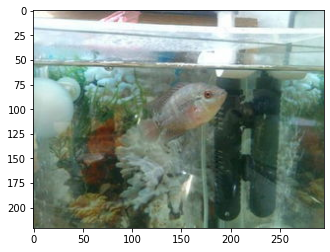

1/1 [==============================] - 0s 215ms/step
------------------------------------------
file: dataset/luohan/ef3d89505bcf91ae.jpg
Main model       : 		 goldfish   	with confidence 46.62
Simple model     : 		 betta   	with confidence 35.56
Grayscale model  : 		 betta   	with confidence 31.23
Arbitrator model : 		 goldfish   	with confidence 43.31
------------------------------------------


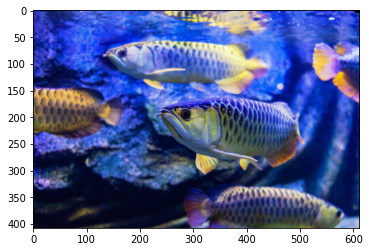

1/1 [==============================] - 0s 17ms/step
------------------------------------------
file: dataset/arowana/istockphoto-1260153360-612x612.jpg
Main model       : 		 betta   	with confidence 45.56
Simple model     : 		 betta   	with confidence 46.76
Grayscale model  : 		 betta   	with confidence 36.61
Arbitrator model : 		 betta   	with confidence 47.45
------------------------------------------


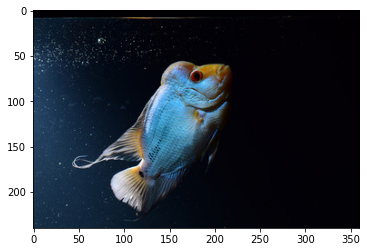

1/1 [==============================] - 0s 22ms/step
------------------------------------------
file: dataset/luohan/240_F_97053754_gjPJ06axjb76ALekXBCeCZ54x6mhupcR.jpg
Main model       : 		 betta   	with confidence 45.50
Simple model     : 		 arowana   	with confidence 32.64
Grayscale model  : 		 arowana   	with confidence 32.46
Arbitrator model : 		 betta   	with confidence 44.27
------------------------------------------


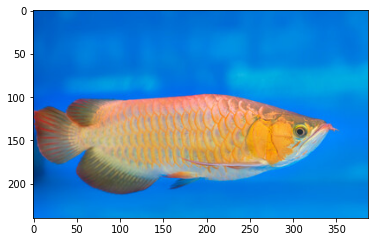

1/1 [==============================] - 0s 17ms/step
------------------------------------------
file: dataset/arowana/240_F_423111684_gNg0s3zTp60Y0tkWtkryMYxlruuIyl6V.jpg
Main model       : 		 goldfish   	with confidence 44.29
Simple model     : 		 arowana   	with confidence 33.86
Grayscale model  : 		 goldfish   	with confidence 30.93
Arbitrator model : 		 goldfish   	with confidence 44.31
------------------------------------------


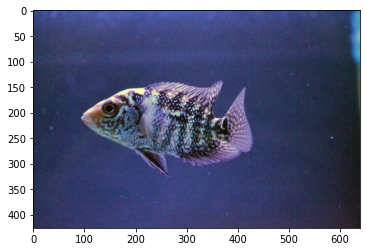

1/1 [==============================] - 0s 17ms/step
------------------------------------------
file: dataset/luohan/1027884-328b3e3c7fd25d53875b623742bf42dd.jpg
Main model       : 		 arowana   	with confidence 43.89
Simple model     : 		 betta   	with confidence 32.40
Grayscale model  : 		 arowana   	with confidence 43.11
Arbitrator model : 		 arowana   	with confidence 45.27
------------------------------------------


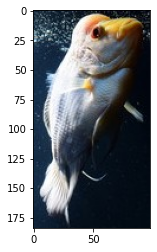

1/1 [==============================] - 0s 16ms/step
------------------------------------------
file: dataset/luohan/Flowerhorn10300.jpg
Main model       : 		 arowana   	with confidence 47.53
Simple model     : 		 arowana   	with confidence 46.49
Grayscale model  : 		 goldfish   	with confidence 46.05
Arbitrator model : 		 arowana   	with confidence 46.80
------------------------------------------


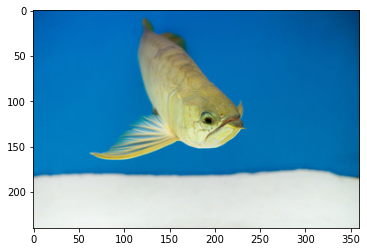

1/1 [==============================] - 0s 17ms/step
------------------------------------------
file: dataset/arowana/240_F_206985055_Vteq1aqM5p0zQqzuV8jNnqMWYvUXjZt5.jpg
Main model       : 		 arowana   	with confidence 33.24
Simple model     : 		 arowana   	with confidence 45.62
Grayscale model  : 		 goldfish   	with confidence 46.34
Arbitrator model : 		 arowana   	with confidence 37.15
------------------------------------------


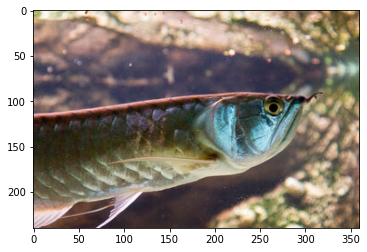

1/1 [==============================] - 0s 18ms/step
------------------------------------------
file: dataset/arowana/240_F_487052495_MO2xrOJP158oNR6AaraC6jxp1NKoAZox.jpg
Main model       : 		 goldfish   	with confidence 31.61
Simple model     : 		 betta   	with confidence 46.49
Grayscale model  : 		 goldfish   	with confidence 32.04
Arbitrator model : 		 goldfish   	with confidence 32.19
------------------------------------------


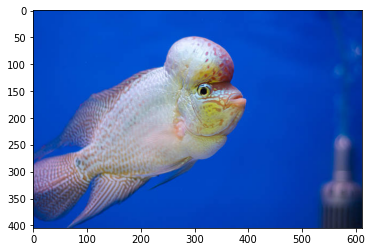

1/1 [==============================] - 0s 18ms/step
------------------------------------------
file: dataset/luohan/istockphoto-535631333-612x612.jpg
Main model       : 		 luohan   	with confidence 28.46
Simple model     : 		 goldfish   	with confidence 33.14
Grayscale model  : 		 luohan   	with confidence 30.30
Arbitrator model : 		 luohan   	with confidence 36.38
------------------------------------------


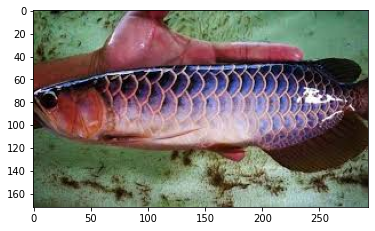

1/1 [==============================] - 0s 18ms/step
------------------------------------------
file: dataset/arowana/images (41).jpg
Main model       : 		 arowana   	with confidence 44.02
Simple model     : 		 luohan   	with confidence 46.22
Grayscale model  : 		 arowana   	with confidence 46.99
Arbitrator model : 		 arowana   	with confidence 42.89
------------------------------------------


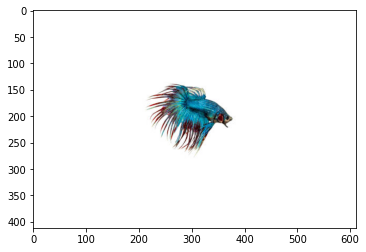

1/1 [==============================] - 0s 16ms/step
------------------------------------------
file: dataset/betta/betta0428.jpg
Main model       : 		 betta   	with confidence 37.87
Simple model     : 		 arowana   	with confidence 45.11
Grayscale model  : 		 goldfish   	with confidence 39.42
Arbitrator model : 		 betta   	with confidence 36.47
------------------------------------------


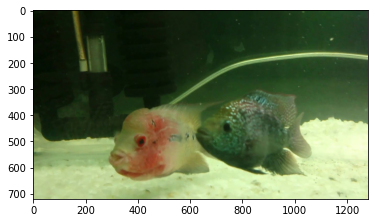

1/1 [==============================] - 0s 17ms/step
------------------------------------------
file: dataset/luohan/maxresdefault (3).jpg
Main model       : 		 arowana   	with confidence 45.44
Simple model     : 		 luohan   	with confidence 42.98
Grayscale model  : 		 goldfish   	with confidence 42.60
Arbitrator model : 		 arowana   	with confidence 29.81
------------------------------------------


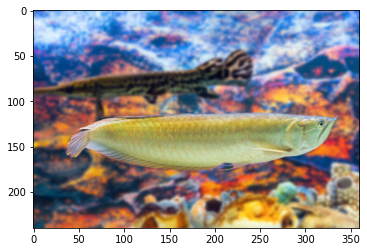

1/1 [==============================] - 0s 18ms/step
------------------------------------------
file: dataset/arowana/240_F_383540799_WbyjRwwHTaCH9j3RQ7Qy38GWR9KNEzob.jpg
Main model       : 		 arowana   	with confidence 47.19
Simple model     : 		 luohan   	with confidence 34.05
Grayscale model  : 		 betta   	with confidence 29.29
Arbitrator model : 		 arowana   	with confidence 35.39
------------------------------------------


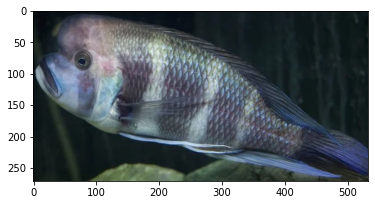

1/1 [==============================] - 0s 16ms/step
------------------------------------------
file: dataset/luohan/Flowerhorn10597.jpg
Main model       : 		 arowana   	with confidence 47.49
Simple model     : 		 luohan   	with confidence 45.00
Grayscale model  : 		 arowana   	with confidence 46.91
Arbitrator model : 		 arowana   	with confidence 45.57
------------------------------------------


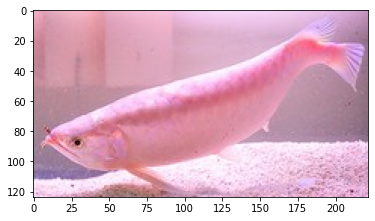

1/1 [==============================] - 0s 20ms/step
------------------------------------------
file: dataset/arowana/Arowana_100797.jpg
Main model       : 		 goldfish   	with confidence 41.50
Simple model     : 		 arowana   	with confidence 47.42
Grayscale model  : 		 goldfish   	with confidence 36.09
Arbitrator model : 		 goldfish   	with confidence 35.54
------------------------------------------


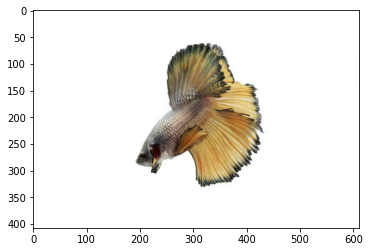

1/1 [==============================] - 0s 17ms/step
------------------------------------------
file: dataset/betta/betta0636.jpg
Main model       : 		 goldfish   	with confidence 38.05
Simple model     : 		 goldfish   	with confidence 34.34
Grayscale model  : 		 goldfish   	with confidence 45.89
Arbitrator model : 		 goldfish   	with confidence 46.43
------------------------------------------


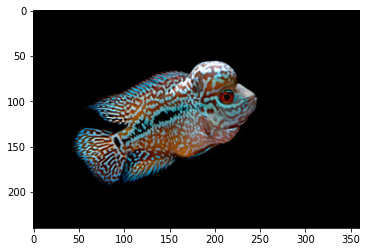

1/1 [==============================] - 0s 18ms/step
------------------------------------------
file: dataset/luohan/240_F_221522748_k0t3sNgPlgGAsBgFA6tmQEUn3FuEnCGO.jpg
Main model       : 		 luohan   	with confidence 32.63
Simple model     : 		 luohan   	with confidence 47.53
Grayscale model  : 		 betta   	with confidence 38.09
Arbitrator model : 		 luohan   	with confidence 45.39
------------------------------------------


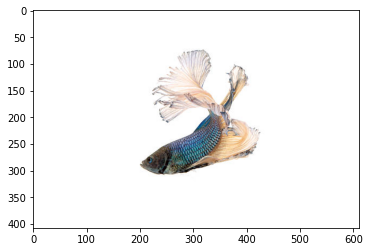

1/1 [==============================] - 0s 20ms/step
------------------------------------------
file: dataset/betta/betta0920.jpg
Main model       : 		 goldfish   	with confidence 39.94
Simple model     : 		 arowana   	with confidence 47.00
Grayscale model  : 		 goldfish   	with confidence 44.89
Arbitrator model : 		 goldfish   	with confidence 42.60
------------------------------------------


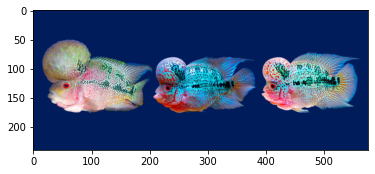

1/1 [==============================] - 0s 19ms/step
------------------------------------------
file: dataset/luohan/240_F_332633863_Umm9xzwGYgTz0R3W3C93ReFZBL4FWvAr.jpg
Main model       : 		 luohan   	with confidence 44.31
Simple model     : 		 betta   	with confidence 31.01
Grayscale model  : 		 goldfish   	with confidence 46.08
Arbitrator model : 		 luohan   	with confidence 42.38
------------------------------------------


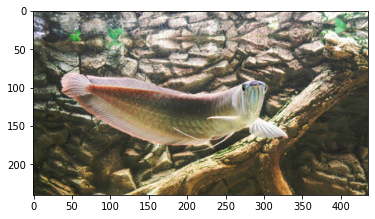

1/1 [==============================] - 0s 17ms/step
------------------------------------------
file: dataset/arowana/240_F_487549302_VbzOWnA4jOnVZ5STBs8ERUc0EdFDZXqv.jpg
Main model       : 		 arowana   	with confidence 32.94
Simple model     : 		 betta   	with confidence 44.87
Grayscale model  : 		 betta   	with confidence 46.86
Arbitrator model : 		 betta   	with confidence 43.30
------------------------------------------


In [28]:
import random

modelGo = load_model("./models/ensemble_best.hdf5")

wrong_pred = df[df.yout !=df.fout]
print(wrong_pred.shape)
# # make predictions
# # 
for i in range(20):
    j = random.randint(0,wrong_pred.shape[0])
    row = wrong_pred.iloc[j]
    res = predict_new_image(modelGo, row.file)
    print("------------------------------------------")
    print("file: " + row.file)
    print("Main model       : \t\t {}   \twith confidence {:.2f}".format(res[0][0], res[0][1]))
    print("Simple model     : \t\t {}   \twith confidence {:.2f}".format(res[1][0], res[1][1]))
    print("Grayscale model  : \t\t {}   \twith confidence {:.2f}".format(res[2][0], res[2][1]))
    print("Arbitrator model : \t\t {}   \twith confidence {:.2f}".format(res[3][0], res[3][1]))
    print("------------------------------------------")


(289, 7)


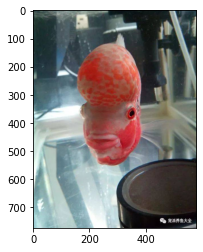

1/1 [==============================] - 0s 225ms/step
------------------------------------------
file: dataset/luohan/c8d922446faafcfc.jpg
Main model       : 		 betta   	with confidence 33.11
Simple model     : 		 goldfish   	with confidence 34.36
Grayscale model  : 		 goldfish   	with confidence 41.13
Arbitrator model : 		 goldfish   	with confidence 33.83
------------------------------------------


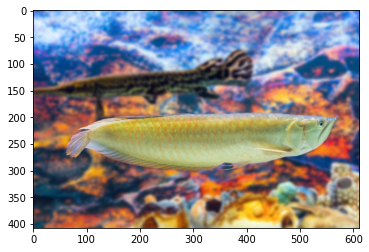

1/1 [==============================] - 0s 17ms/step
------------------------------------------
file: dataset/arowana/istockphoto-1278984693-612x612.jpg
Main model       : 		 arowana   	with confidence 47.04
Simple model     : 		 luohan   	with confidence 33.48
Grayscale model  : 		 betta   	with confidence 33.73
Arbitrator model : 		 arowana   	with confidence 32.80
------------------------------------------


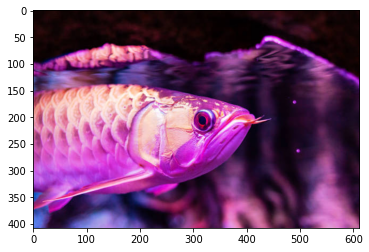

1/1 [==============================] - 0s 17ms/step
------------------------------------------
file: dataset/arowana/istockphoto-1281983272-612x612.jpg
Main model       : 		 goldfish   	with confidence 30.68
Simple model     : 		 arowana   	with confidence 46.94
Grayscale model  : 		 arowana   	with confidence 44.77
Arbitrator model : 		 arowana   	with confidence 46.00
------------------------------------------


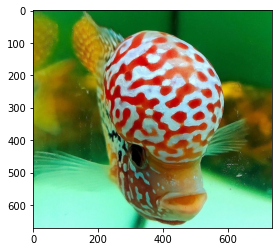

1/1 [==============================] - 0s 17ms/step
------------------------------------------
file: dataset/luohan/Flowerhorn10794.jpg
Main model       : 		 goldfish   	with confidence 46.86
Simple model     : 		 luohan   	with confidence 47.42
Grayscale model  : 		 goldfish   	with confidence 33.57
Arbitrator model : 		 goldfish   	with confidence 40.16
------------------------------------------


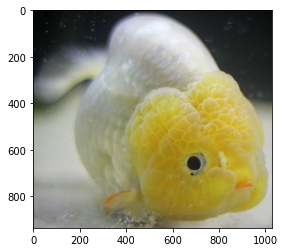

1/1 [==============================] - 0s 19ms/step
------------------------------------------
file: dataset/goldfish/Goldfish1034.jpg
Main model       : 		 arowana   	with confidence 40.57
Simple model     : 		 betta   	with confidence 28.53
Grayscale model  : 		 goldfish   	with confidence 41.39
Arbitrator model : 		 goldfish   	with confidence 29.20
------------------------------------------


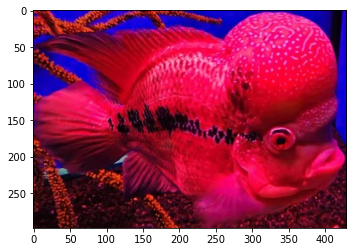

1/1 [==============================] - 0s 17ms/step
------------------------------------------
file: dataset/luohan/Flowerhorn10672.jpg
Main model       : 		 betta   	with confidence 44.22
Simple model     : 		 luohan   	with confidence 47.43
Grayscale model  : 		 luohan   	with confidence 47.49
Arbitrator model : 		 luohan   	with confidence 42.42
------------------------------------------


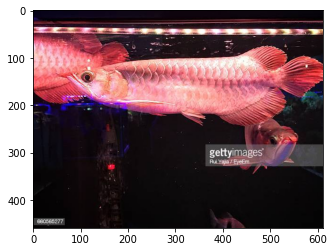

1/1 [==============================] - 0s 18ms/step
------------------------------------------
file: dataset/arowana/gettyimages-660565277-612x612.jpg
Main model       : 		 arowana   	with confidence 28.76
Simple model     : 		 betta   	with confidence 47.17
Grayscale model  : 		 betta   	with confidence 46.70
Arbitrator model : 		 betta   	with confidence 46.75
------------------------------------------


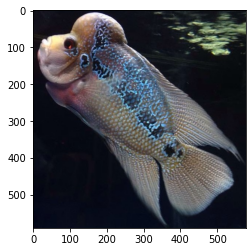

1/1 [==============================] - 0s 19ms/step
------------------------------------------
file: dataset/luohan/Flowerhorn10924.jpg
Main model       : 		 luohan   	with confidence 47.51
Simple model     : 		 luohan   	with confidence 47.48
Grayscale model  : 		 luohan   	with confidence 42.88
Arbitrator model : 		 luohan   	with confidence 47.52
------------------------------------------


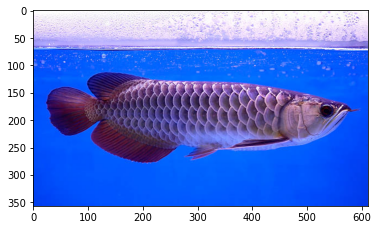

1/1 [==============================] - 0s 19ms/step
------------------------------------------
file: dataset/arowana/istockphoto-469205982-612x612.jpg
Main model       : 		 goldfish   	with confidence 39.66
Simple model     : 		 arowana   	with confidence 47.09
Grayscale model  : 		 betta   	with confidence 36.76
Arbitrator model : 		 goldfish   	with confidence 32.57
------------------------------------------


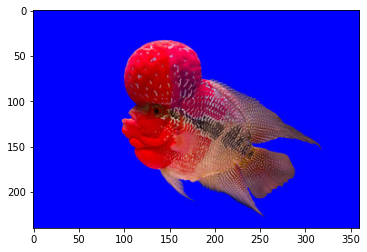

1/1 [==============================] - 0s 19ms/step
------------------------------------------
file: dataset/luohan/240_F_82248387_GGBZTuM3KyP8fyytkmmSGj0DdsaNXVDe.jpg
Main model       : 		 goldfish   	with confidence 44.99
Simple model     : 		 luohan   	with confidence 47.54
Grayscale model  : 		 goldfish   	with confidence 30.92
Arbitrator model : 		 goldfish   	with confidence 31.19
------------------------------------------


In [32]:
import random

modelGo = load_model("./models/ensemble_best.hdf5")

wrong_pred = df[df.gout == df.fout]
wrong_pred = wrong_pred[wrong_pred.gout != wrong_pred.mout]
print(wrong_pred.shape)
# # make predictions
# # 
for i in range(10):
    j = random.randint(0,wrong_pred.shape[0])
    row = wrong_pred.iloc[j]
    res = predict_new_image(modelGo, row.file)
    print("------------------------------------------")
    print("file: " + row.file)
    print("Main model       : \t\t {}   \twith confidence {:.2f}".format(res[0][0], res[0][1]))
    print("Simple model     : \t\t {}   \twith confidence {:.2f}".format(res[1][0], res[1][1]))
    print("Grayscale model  : \t\t {}   \twith confidence {:.2f}".format(res[2][0], res[2][1]))
    print("Arbitrator model : \t\t {}   \twith confidence {:.2f}".format(res[3][0], res[3][1]))
    print("------------------------------------------")
